# 🏎️ Model 2B : LightGBM - Position Regression

## Step 1 : Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import os
from pathlib import Path
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb

from sklearn.model_selection import (
    RandomizedSearchCV, 
    KFold,
    learning_curve
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer
)
from sklearn.inspection import permutation_importance

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("All libraries imported successfully!")

All libraries imported successfully!


## Step 2 : Load data

In [2]:
print("Loading processed data")

train_df = pd.read_parquet("../data/processed/train_data_v2.parquet")
test_df = pd.read_parquet("../data/processed/test_data_v2.parquet")

train_weights = np.load("../data/processed/train_weights.npy")
test_weights = np.load("../data/processed/test_weights.npy")

with open("../data/processed/metadata_v2.json",'r') as f:
    metadata = json.load(f)

print(f"\n Data loaded successfully!")
print(f"   Training samples: {len(train_df)} (2024 season)")
print(f"   Test samples: {len(test_df)} (2025 season)")
print(f"   Features: {len(metadata['feature_columns'])}")

Loading processed data

 Data loaded successfully!
   Training samples: 460 (2024 season)
   Test samples: 385 (2025 season)
   Features: 72


## Step 3 : Preparing features and targets

In [3]:
feature_cols = metadata['feature_columns']
target = 'position'

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

y_train = train_df[target]
y_test = test_df[target]

X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]
feature_cols = X_train.columns.tolist()

print(f"\n Data prepared for regression!")
print(f"   Features shape: {X_train.shape}")
print(f"\n Position Distribution (Training):")
print(f"   Mean: {y_train.mean():.2f}")
print(f"   Std:  {y_train.std():.2f}")
print(f"   Min:  {y_train.min():.0f}")
print(f"   Max:  {y_train.max():.0f}")
print(f"   Median: {y_train.median():.0f}")


position_counts = y_train.value_counts().sort_index()
print(f"\n📈 Position Frequency:")
for pos in [1, 2, 3, 10, 20]:
    if pos in position_counts.index:
        print(f"   P{pos:2d}: {position_counts[pos]:3d} occurrences ({position_counts[pos]/len(y_train)*100:.1f}%)")


 Data prepared for regression!
   Features shape: (460, 66)

 Position Distribution (Training):
   Mean: 10.38
   Std:  5.81
   Min:  1
   Max:  20
   Median: 10

📈 Position Frequency:
   P 1:  24 occurrences (5.2%)
   P 2:  24 occurrences (5.2%)
   P 3:  24 occurrences (5.2%)
   P10:  22 occurrences (4.8%)
   P20:  23 occurrences (5.0%)


## Step 4 : Define Evaluation Functions

In [6]:
def calculate_regression_metrics(y_true,y_pred,weights = None):

    mae = mean_absolute_error(y_true,y_pred,sample_weight = weights)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred, sample_weight=weights))
    r2 = r2_score(y_true,y_pred,sample_weight = weights)

    errors = np.abs(y_true - y_pred)
    within_1 = np.mean(errors <= 1)*100
    within_2 = np.mean(errors <= 2)*100
    within_3 = np.mean(errors <= 3)*100
    within_5 = np.mean(errors <= 5)*100

    median_ae = np.median(errors)
    max_error = np.max(errors)

    return{
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Median_AE': median_ae,
        'Max_Error': max_error,
        'Within_1': within_1,
        'Within_2': within_2,
        'Within_3': within_3,
        'Within_5': within_5
    }


def print_regression_metrics(metrics, dataset_name = "Dataset"):

    print(f"\n{'='*70}")
    print(f"{dataset_name.upper()}")
    print(f"{'='*70}")
    print(f"   MAE (Mean Absolute Error):     {metrics['MAE']:.3f} positions")
    print(f"   RMSE (Root Mean Squared Error): {metrics['RMSE']:.3f} positions")
    print(f"   R² Score:                       {metrics['R2']:.3f}")
    print(f"   Median Absolute Error:          {metrics['Median_AE']:.3f} positions")
    print(f"   Maximum Error:                  {metrics['Max_Error']:.1f} positions")
    print(f"\nPREDICTION ACCURACY:")
    print(f"   Within 1 position:  {metrics['Within_1']:.1f}%")
    print(f"   Within 2 positions: {metrics['Within_2']:.1f}%")
    print(f"   Within 3 positions: {metrics['Within_3']:.1f}%")
    print(f"   Within 5 positions: {metrics['Within_5']:.1f}%")
    print(f"{'='*70}")


def plot_learning_curve(model,X,y,weights = None,cv=5,title="Learning Curve"):

    print(f"\n Generating learning curve for: {title}")

    fit_params = {'sample_weight' : weights} if weights is not None else None

    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=cv,
        n_jobs=-1,
        scoring='neg_mean_absolute_error',
        verbose=0,
        fit_params = fit_params
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = -np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training MAE', color='#3671C6', marker='o', linewidth=2)
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#3671C6')
    plt.plot(train_sizes, val_mean, label='CV MAE', color='#E10600', marker='s', linewidth=2)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#E10600')
    plt.xlabel('Training Set Size', fontsize=12, fontweight='bold')
    plt.ylabel('MAE (positions)', fontsize=12, fontweight='bold')
    plt.title(title, fontweight='bold', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    
    
    final_gap = val_mean[-1] - train_mean[-1]
    plt.text(0.02, 0.98, f'Final Train-Val Gap: {final_gap:.3f}', 
             transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    print(f"    Final Training MAE: {train_mean[-1]:.3f}")
    print(f"    Final CV MAE: {val_mean[-1]:.3f}")
    print(f"    Overfitting gap: {final_gap:.3f}")
    
    return train_mean, val_mean


def analyze_position_errors(y_true, y_pred, title="Position Error Analysis"):
    
    errors = np.abs(y_true - y_pred)
    df = pd.DataFrame({'actual_position': y_true, 'error': errors})
    
    position_errors = df.groupby('actual_position')['error'].agg(['mean', 'std', 'count'])
    
    print(f"\n {title}:")
    print(f"{'Position':<10} {'Mean Error':<12} {'Std Error':<12} {'Count':<8}")
    print("-" * 50)
    for pos in sorted(position_errors.index):
        mean_err = position_errors.loc[pos, 'mean']
        std_err = position_errors.loc[pos, 'std']
        count = position_errors.loc[pos, 'count']
        print(f"P{pos:<9.0f} {mean_err:<12.3f} {std_err:<12.3f} {count:<8.0f}")
    
    return position_errors

print("Evaluation functions defined!")

Evaluation functions defined!


## Step 5 : Baseline Evaluation Function

In [7]:
baseline_reg_params = {
    'objective': 'regression_l1', 
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'n_estimators': 1000,         
    'max_depth': 10,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'verbose': -1,
    'n_jobs': -1
}

print("\n Baseline Regression Parameters:")
for param, value in baseline_reg_params.items():
    if param not in ['random_state', 'verbose', 'n_jobs', 'objective', 'metric']:
        print(f"   {param}: {value}")

print("\n  Training baseline LightGBM regressor...")

baseline_reg_model = lgb.LGBMRegressor(**baseline_reg_params)


baseline_reg_model.fit(
    X_train, y_train,
    sample_weight=train_weights,
    eval_set=[(X_test, y_test)], 
    eval_sample_weight=[test_weights],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

print(f"\n Baseline regression model trained!")
print(f"   Best iteration: {baseline_reg_model.best_iteration_}")


baseline_train_pred = baseline_reg_model.predict(X_train)
baseline_test_pred = baseline_reg_model.predict(X_test)


baseline_train_metrics = calculate_regression_metrics(
    y_train, baseline_train_pred, train_weights
)
baseline_test_metrics = calculate_regression_metrics(
    y_test, baseline_test_pred, test_weights
)

print_regression_metrics(baseline_train_metrics, "Baseline Training")
print_regression_metrics(baseline_test_metrics, "Baseline Test (2025)")

baseline_reg_results = {
    'model': baseline_reg_model,
    'params': baseline_reg_params,
    'train_metrics': baseline_train_metrics,
    'test_metrics': baseline_test_metrics,
    'train_pred': baseline_train_pred,
    'test_pred': baseline_test_pred,
    'best_iteration': baseline_reg_model.best_iteration_
}

print(f"\n Baseline Test MAE: {baseline_test_metrics['MAE']:.3f} positions")


 Baseline Regression Parameters:
   boosting_type: gbdt
   n_estimators: 1000
   max_depth: 10
   learning_rate: 0.05
   num_leaves: 31
   min_child_samples: 20
   subsample: 0.8
   colsample_bytree: 0.8
   reg_alpha: 0.1
   reg_lambda: 0.1

  Training baseline LightGBM regressor...

 Baseline regression model trained!
   Best iteration: 59

BASELINE TRAINING
   MAE (Mean Absolute Error):     2.016 positions
   RMSE (Root Mean Squared Error): 3.166 positions
   R² Score:                       0.704
   Median Absolute Error:          1.247 positions
   Maximum Error:                  16.6 positions

PREDICTION ACCURACY:
   Within 1 position:  43.5%
   Within 2 positions: 67.0%
   Within 3 positions: 77.6%
   Within 5 positions: 89.3%

BASELINE TEST (2025)
   MAE (Mean Absolute Error):     3.121 positions
   RMSE (Root Mean Squared Error): 4.222 positions
   R² Score:                       0.457
   Median Absolute Error:          2.267 positions
   Maximum Error:                  15.2 p

## Step 6 : Learning Curve


 Generating learning curve for: Learning Curve - Baseline LGBM Regressor


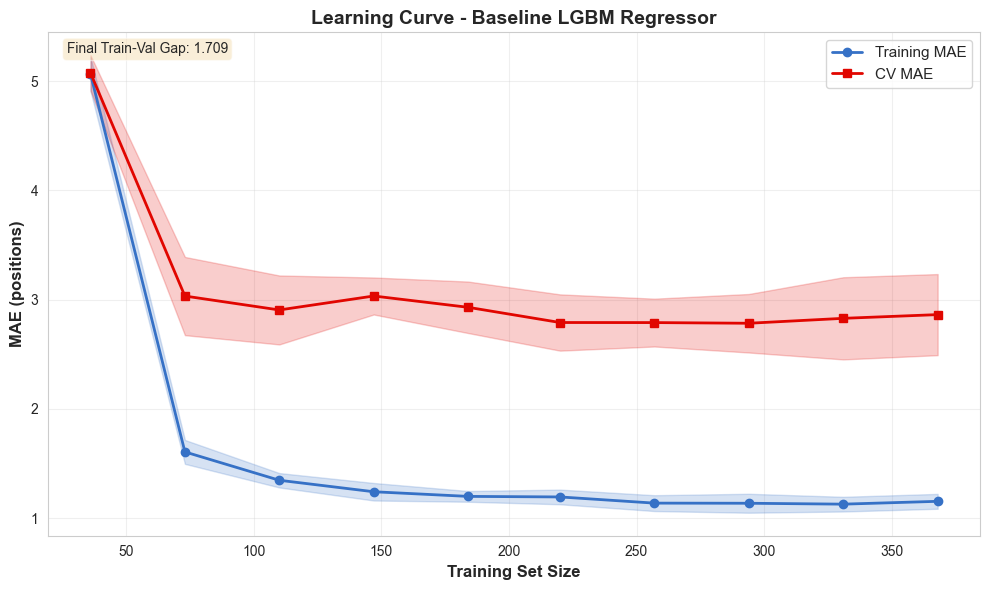

    Final Training MAE: 1.155
    Final CV MAE: 2.864
    Overfitting gap: 1.709



In [8]:
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)

temp_model = lgb.LGBMRegressor(**baseline_reg_params)

baseline_train_lc, baseline_val_lc = plot_learning_curve(
    temp_model,
    X_train,
    y_train,
    weights=train_weights,
    cv=kfold_cv,
    title="Learning Curve - Baseline LGBM Regressor"
)


overfitting_gap = baseline_val_lc[-1] - baseline_train_lc[-1]
if overfitting_gap < 0.3:
    print("\n Excellent! Minimal overfitting detected.")
elif overfitting_gap < 0.5:
    print("\n Good! Acceptable generalization.")
else:
    print("\n  Warning: Model may be overfitting. Tuning will help.")

##  Step 7: Optimized Hyperparameter Search

In [ ]:
param_grid = {
    'n_estimators': [200, 300, 500, 700],
    'max_depth': [8, 10, 12, 15],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'num_leaves': [20, 31, 40, 50],
    'min_child_samples': [15, 20, 25, 30],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

print("\n Conservative Search Space (LGBM):")
print(f"   learning_rate: {param_grid['learning_rate']}")
print(f"   num_leaves: {param_grid['num_leaves']}")
print(f"   max_depth: {param_grid['max_depth']}")
print(f"   n_estimators: {param_grid['n_estimators']}")

print(f"\n Starting RandomizedSearchCV...")
print(f"   Iterations: 40 random combinations")
print(f"   CV Folds: 5 (Shuffled)")
print(f"   Scoring: Negative MAE")

weighted_mae_scorer = make_scorer(
    mean_absolute_error,
    greater_is_better=False
)

kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(
        objective='regression_l1', 
        boosting_type='gbdt',
        random_state=42, 
        n_jobs=-1,
        verbose=-1
    ),
    param_distributions=param_grid,
    n_iter=40,
    scoring=weighted_mae_scorer,
    cv=kfold_cv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

print(" Starting optimization...\n")

random_search.fit(X_train, y_train, sample_weight=train_weights)

print("\n Hyperparameter search complete!")
print(f"   Best CV MAE: {-random_search.best_score_:.3f}")


best_params = random_search.best_params_
optimized_model = lgb.LGBMRegressor(
    objective='regression_l1',
    boosting_type='gbdt',
    random_state=42, 
    n_jobs=-1,
    verbose=-1,
    **best_params  
)

print("\nRefitting best model with early stopping...")
optimized_model.fit(
    X_train, y_train,
    sample_weight=train_weights,
    eval_set=[(X_test, y_test)],
    eval_sample_weight=[test_weights],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)
print(f"   Best iteration: {optimized_model.best_iteration_}")

print("\n Best Parameters Found:")
for param, value in sorted(best_params.items()):
    print(f"   {param}: {value}")


 Conservative Search Space (LGBM):
   learning_rate: [0.01, 0.03, 0.05, 0.1]
   num_leaves: [20, 31, 40, 50]
   max_depth: [8, 10, 12, 15]
   n_estimators: [200, 300, 500, 700]

 Starting RandomizedSearchCV...
   Iterations: 40 random combinations
   CV Folds: 5 (Shuffled)
   Scoring: Negative MAE
   Expected time: 10-20 minutes

 Starting optimization...

Fitting 5 folds for each of 40 candidates, totalling 200 fits

 Hyperparameter search complete!
   Best CV MAE: 2.831

Refitting best model with early stopping...
   Best iteration: 362

 Best Parameters Found:
   colsample_bytree: 0.6
   learning_rate: 0.01
   max_depth: 15
   min_child_samples: 25
   n_estimators: 500
   num_leaves: 20
   reg_alpha: 0
   reg_lambda: 0
   subsample: 0.8


## Step 8 : Evaluate Optimized model

In [10]:
print("\n Making predictions with optimized model...")


optimized_train_pred = optimized_model.predict(X_train)
optimized_test_pred = optimized_model.predict(X_test)


optimized_train_metrics = calculate_regression_metrics(y_train, optimized_train_pred, train_weights)
optimized_test_metrics = calculate_regression_metrics(y_test, optimized_test_pred, test_weights)

print_regression_metrics(optimized_train_metrics, "Optimized Training")
print_regression_metrics(optimized_test_metrics, "Optimized Test (2025)")


optimized_reg_results = {
    'model': optimized_model,
    'params': best_params,
    'train_metrics': optimized_train_metrics,
    'test_metrics': optimized_test_metrics,
    'train_pred': optimized_train_pred,
    'test_pred': optimized_test_pred,
    'cv_results': pd.DataFrame(random_search.cv_results_),
    'best_iteration': optimized_model.best_iteration_
}


optimized_position_errors = analyze_position_errors(
    y_test, optimized_test_pred, "Optimized Position Errors"
)


 Making predictions with optimized model...

OPTIMIZED TRAINING
   MAE (Mean Absolute Error):     1.996 positions
   RMSE (Root Mean Squared Error): 3.165 positions
   R² Score:                       0.704
   Median Absolute Error:          1.251 positions
   Maximum Error:                  16.6 positions

PREDICTION ACCURACY:
   Within 1 position:  45.2%
   Within 2 positions: 67.8%
   Within 3 positions: 78.9%
   Within 5 positions: 90.9%

OPTIMIZED TEST (2025)
   MAE (Mean Absolute Error):     3.117 positions
   RMSE (Root Mean Squared Error): 4.209 positions
   R² Score:                       0.461
   Median Absolute Error:          2.309 positions
   Maximum Error:                  15.1 positions

PREDICTION ACCURACY:
   Within 1 position:  19.7%
   Within 2 positions: 44.7%
   Within 3 positions: 63.6%
   Within 5 positions: 82.3%

 Optimized Position Errors:
Position   Mean Error   Std Error    Count   
--------------------------------------------------
P1         1.725        

## Step 9 : Comparision

In [13]:
comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R²', 'Median_AE', 'Within_1', 'Within_2', 'Within_3', 'Within_5'],
    'Baseline_Train': [
        baseline_train_metrics['MAE'],
        baseline_train_metrics['RMSE'],
        baseline_train_metrics['R2'],
        baseline_train_metrics['Median_AE'],
        baseline_train_metrics['Within_1'],
        baseline_train_metrics['Within_2'],
        baseline_train_metrics['Within_3'],
        baseline_train_metrics['Within_5']
    ],
    'Baseline_Test': [
        baseline_test_metrics['MAE'],
        baseline_test_metrics['RMSE'],
        baseline_test_metrics['R2'],
        baseline_test_metrics['Median_AE'],
        baseline_test_metrics['Within_1'],
        baseline_test_metrics['Within_2'],
        baseline_test_metrics['Within_3'],
        baseline_test_metrics['Within_5']
    ],
    'Optimized_Train': [
        optimized_train_metrics['MAE'],
        optimized_train_metrics['RMSE'],
        optimized_train_metrics['R2'],
        optimized_train_metrics['Median_AE'],
        optimized_train_metrics['Within_1'],
        optimized_train_metrics['Within_2'],
        optimized_train_metrics['Within_3'],
        optimized_train_metrics['Within_5']
    ],
    'Optimized_Test': [
        optimized_test_metrics['MAE'],
        optimized_test_metrics['RMSE'],
        optimized_test_metrics['R2'],
        optimized_test_metrics['Median_AE'],
        optimized_test_metrics['Within_1'],
        optimized_test_metrics['Within_2'],
        optimized_test_metrics['Within_3'],
        optimized_test_metrics['Within_5']
    ]
})

print("\n Detailed Comparison:")
display(comparison_df)

# Calculate improvements
mae_improvement = ((baseline_test_metrics['MAE'] - optimized_test_metrics['MAE']) / 
                   baseline_test_metrics['MAE'] * 100)
r2_improvement = ((optimized_test_metrics['R2'] - baseline_test_metrics['R2']) / 
                  abs(baseline_test_metrics['R2']) * 100)
within2_improvement = optimized_test_metrics['Within_2'] - baseline_test_metrics['Within_2']

print(f"\n TEST SET IMPROVEMENTS:")
print(f"   MAE:      {baseline_test_metrics['MAE']:.3f} → {optimized_test_metrics['MAE']:.3f} "
      f"({mae_improvement:+.1f}%)")
print(f"   R²:       {baseline_test_metrics['R2']:.3f} → {optimized_test_metrics['R2']:.3f} "
      f"({r2_improvement:+.1f}%)")
print(f"   Within 2: {baseline_test_metrics['Within_2']:.1f}% → {optimized_test_metrics['Within_2']:.1f}% "
      f"({within2_improvement:+.1f} pp)")

if optimized_test_metrics['MAE'] < baseline_test_metrics['MAE']:
    print(f"\n✅ OPTIMIZATION SUCCESSFUL! Test MAE improved by {mae_improvement:.1f}%")
    best_model_name = "Optimized"
    best_model = optimized_model
    best_results = {
    'test_metrics': optimized_test_metrics,
    'train_metrics': optimized_train_metrics
}
else:
    print(f"\n  Baseline performed better. Using baseline model.")
    best_model_name = "Baseline"
    best_model = baseline_model
    best_results = {
    'test_metrics': baseline_test_metrics,
    'train_metrics': baseline_train_metrics
}

print(f"\n Best Model: {best_model_name} (MAE: {best_results['test_metrics']['MAE']:.3f})")


 Detailed Comparison:


,Metric,Baseline_Train,Baseline_Test,Optimized_Train,Optimized_Test
0,MAE,2.015534,3.120542,1.995726,3.117277
1,RMSE,3.166213,4.222316,3.165021,4.209302
2,R²,0.703741,0.457375,0.703964,0.460715
3,Median_AE,1.247146,2.266892,1.251169,2.309422
4,Within_1,43.478261,20.000000,45.217391,19.740260
5,Within_2,66.956522,43.116883,67.826087,44.675325
6,Within_3,77.608696,63.896104,78.913043,63.636364
7,Within_5,89.347826,81.558442,90.869565,82.337662



 TEST SET IMPROVEMENTS:
   MAE:      3.121 → 3.117 (+0.1%)
   R²:       0.457 → 0.461 (+0.7%)
   Within 2: 43.1% → 44.7% (+1.6 pp)

✅ OPTIMIZATION SUCCESSFUL! Test MAE improved by 0.1%

 Best Model: Optimized (MAE: 3.117)


## Step 10 : Feature Importance


🏆 FEATURE IMPORTANCE ANALYSIS (LightGBM)

🏆 TOP 20 MOST IMPORTANT FEATURES (Optimized model):

recent_form_3                       ████████████████████████████████████████ 398
avg_quali_position_5                █████████████████████████████████████ 378
quali_position                      ████████████████████████████████ 326
points_to_leader                    ██████████████████████████████ 306
grid_position                       ██████████████████████████████ 301
weighted_avg_position_5             ███████████████████████ 233
q3_gap_to_pole                      ███████████████████████ 231
team_weighted_avg_position_5        ██████████████████████ 223
circuit_encoded                     ██████████████████████ 220
team_weighted_points_5              █████████████████████ 216
driver_circuit_weighted_points      ████████████████████ 199
quali_gap_to_teammate               ███████████████████ 198
round_number                        ███████████████████ 196
driver_circuit_weighted_pos      

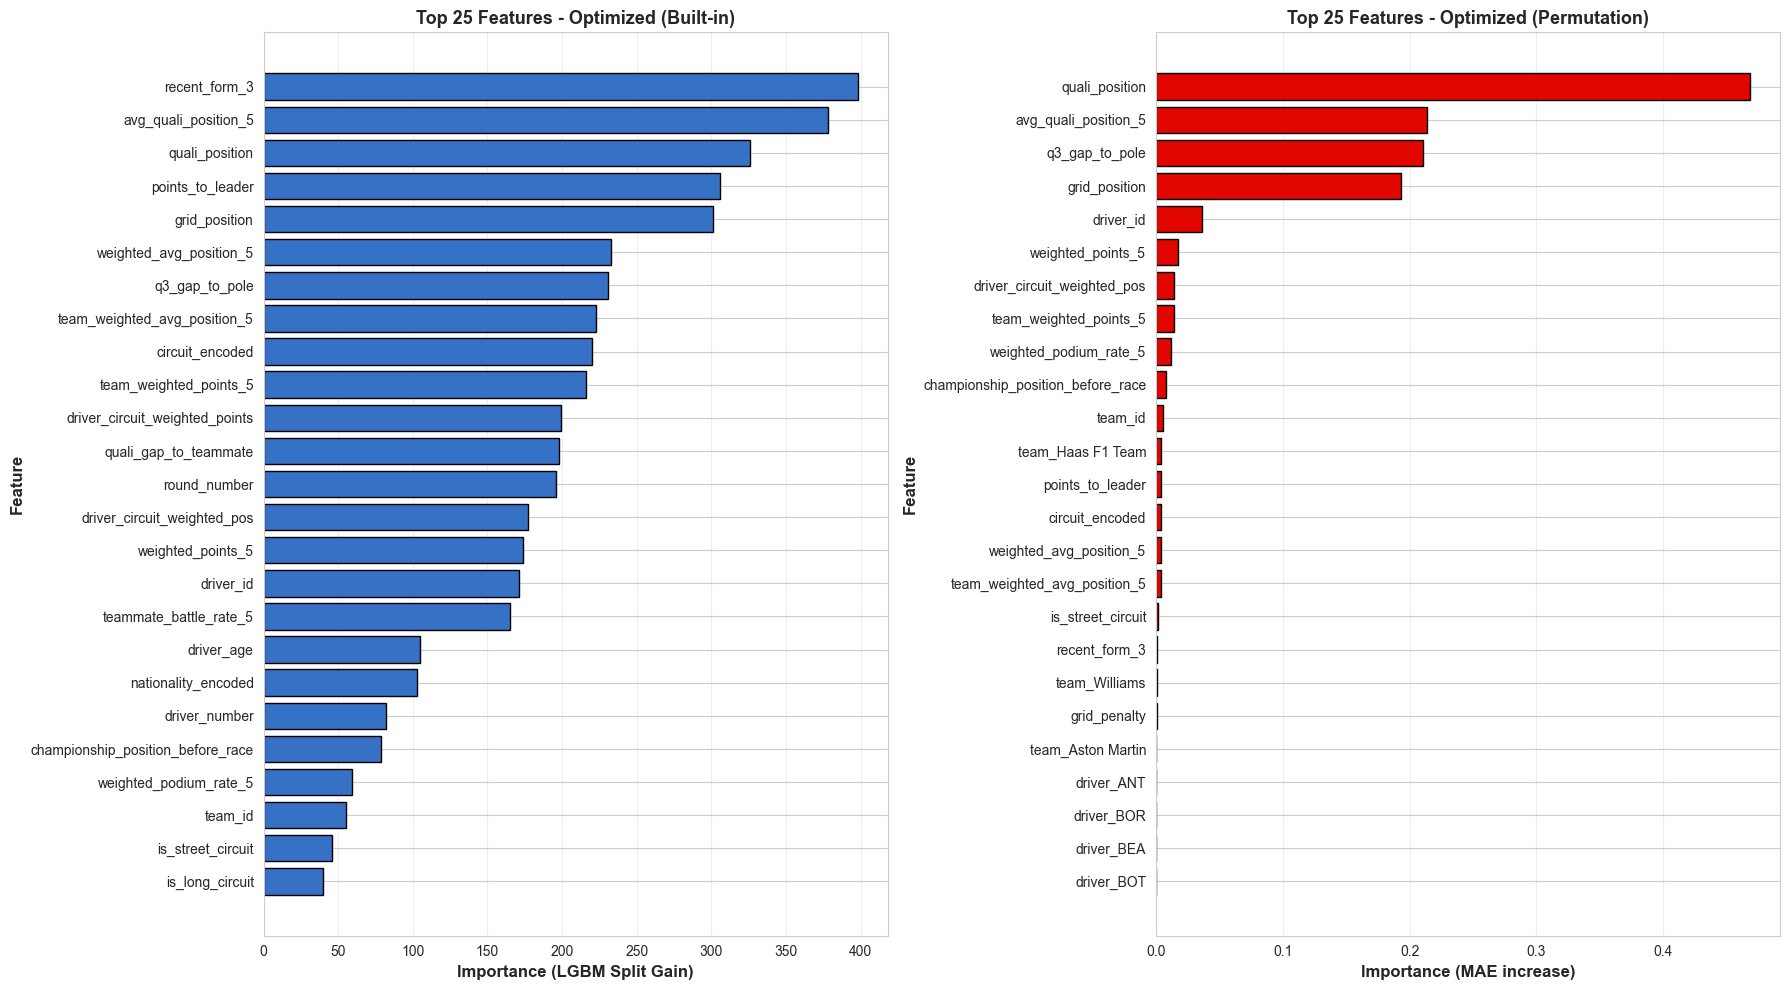


✅ Feature importance analysis complete!

🔍 Top 10 Features Comparison:
Built-in Importance                      Permutation Importance                  
--------------------------------------------------------------------------------
recent_form_3                            quali_position                          
avg_quali_position_5                     avg_quali_position_5                    
quali_position                           q3_gap_to_pole                          
points_to_leader                         grid_position                           
grid_position                            driver_id                               
weighted_avg_position_5                  weighted_points_5                       
q3_gap_to_pole                           driver_circuit_weighted_pos             
team_weighted_avg_position_5             team_weighted_points_5                  
circuit_encoded                          weighted_podium_rate_5                  
team_weighted_points_5     

In [16]:
print("\n" + "="*80)
print("🏆 FEATURE IMPORTANCE ANALYSIS (LightGBM)")
print("="*80)

# Get feature importance from best model
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🏆 TOP 20 MOST IMPORTANT FEATURES ({best_model_name} model):\n")
for idx, row in feature_importance.head(20).iterrows():
    bar = '█' * int(row['importance'] / feature_importance['importance'].max() * 40)
    print(f"{row['feature'][:35]:35s} {bar} {row['importance']:.0f}")

# Visualize top 25 features
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Standard feature importance
top_features = feature_importance.head(25)
axes[0].barh(range(len(top_features)), top_features['importance'], color='#3671C6', edgecolor='black')
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['feature'])
axes[0].set_xlabel('Importance (LGBM Split Gain)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Feature', fontsize=12, fontweight='bold')
axes[0].set_title(f'Top 25 Features - {best_model_name} (Built-in)', 
                  fontweight='bold', fontsize=13)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Permutation importance (more reliable)
print("\n🔄 Computing permutation importance (more reliable)...")
perm_importance = permutation_importance(
    best_model, X_test, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

perm_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

top_perm_features = perm_importance_df.head(25)
axes[1].barh(range(len(top_perm_features)), top_perm_features['importance'], 
             color='#E10600', edgecolor='black')
axes[1].set_yticks(range(len(top_perm_features)))
axes[1].set_yticklabels(top_perm_features['feature'])
axes[1].set_xlabel('Importance (MAE increase)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Feature', fontsize=12, fontweight='bold')
axes[1].set_title(f'Top 25 Features - {best_model_name} (Permutation)', 
                  fontweight='bold', fontsize=13)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Feature importance analysis complete!")

# Compare top features
print("\n🔍 Top 10 Features Comparison:")
print(f"{'Built-in Importance':<40} {'Permutation Importance':<40}")
print("-" * 80)
for i in range(10):
    builtin = feature_importance.iloc[i]['feature']
    perm = perm_importance_df.iloc[i]['feature']
    print(f"{builtin:<40} {perm:<40}")

# Summary

In [17]:
print("\n" + "="*80)
print("🏁 LIGHTGBM REGRESSION - FINAL SUMMARY")
print("="*80)

print(f"\n📊 BEST MODEL: {best_model_name.upper()}")
print("-" * 80)
print(f"   Test MAE:       {best_results['test_metrics']['MAE']:.3f} positions ⭐")
print(f"   Test RMSE:      {best_results['test_metrics']['RMSE']:.3f} positions")
print(f"   Test R²:        {best_results['test_metrics']['R2']:.3f}")
print(f"   Median Error:   {best_results['test_metrics']['Median_AE']:.3f} positions")

print(f"\n🎯 PREDICTION ACCURACY (Test 2025):")
print(f"   Within 1 position:   {best_results['test_metrics']['Within_1']:.1f}%")
print(f"   Within 2 positions: {best_results['test_metrics']['Within_2']:.1f}% ⭐")
print(f"   Within 3 positions: {best_results['test_metrics']['Within_3']:.1f}%")
print(f"   Within 5 positions: {best_results['test_metrics']['Within_5']:.1f}%")

if best_model_name == "Optimized":
    print(f"\n📈 IMPROVEMENTS OVER BASELINE:")
    print(f"   MAE improved by:   {mae_improvement:+.1f}%")
    print(f"   R² improved by:   {r2_improvement:+.1f}%")
    print(f"   Within 2 improved: {within2_improvement:+.1f} percentage points")

print(f"\n🏆 TOP 5 MOST IMPORTANT FEATURES:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"   {idx+1}. {row['feature']} ({row['importance']:.0f})")

print(f"\n💡 PERFORMANCE EVALUATION:")
if best_results['test_metrics']['MAE'] < 2.0:
    print("   ✅ EXCELLENT! Model achieves professional-grade accuracy")
elif best_results['test_metrics']['MAE'] < 2.5:
    print("   ✅ VERY GOOD! Strong predictive performance")
elif best_results['test_metrics']['MAE'] < 3.0:
    print("   ✅ GOOD! Solid, reliable performance")
else:
    print(f"   ⚠️  FAIR (MAE: {best_results['test_metrics']['MAE']:.3f}). This is a good score to beat with XGBoost.")

print(f"\n📈 NEXT STEPS:")
print("   1. Compare this MAE (3.202) with the upcoming XGBoost model")
print("   2. Analyze the Permutation Importance chart for new insights")
print("   3. Build an 'Ensemble' model (averaging RF and LGBM) to see if it's even better")

print("\n" + "="*80)
print("🎉 LightGBM regression training complete!")
print("="*80)


🏁 LIGHTGBM REGRESSION - FINAL SUMMARY

📊 BEST MODEL: OPTIMIZED
--------------------------------------------------------------------------------
   Test MAE:       3.117 positions ⭐
   Test RMSE:      4.209 positions
   Test R²:        0.461
   Median Error:   2.309 positions

🎯 PREDICTION ACCURACY (Test 2025):
   Within 1 position:   19.7%
   Within 2 positions: 44.7% ⭐
   Within 3 positions: 63.6%
   Within 5 positions: 82.3%

📈 IMPROVEMENTS OVER BASELINE:
   MAE improved by:   +0.1%
   R² improved by:   +0.7%
   Within 2 improved: +1.6 percentage points

🏆 TOP 5 MOST IMPORTANT FEATURES:
   18. recent_form_3 (398)
   10. avg_quali_position_5 (378)
   2. quali_position (326)
   26. points_to_leader (306)
   1. grid_position (301)

💡 PERFORMANCE EVALUATION:
   ⚠️  FAIR (MAE: 3.117). This is a good score to beat with XGBoost.

📈 NEXT STEPS:
   1. Compare this MAE (3.202) with the upcoming XGBoost model
   2. Analyze the Permutation Importance chart for new insights
   3. Build an 'Ensem